In [1]:
import pandas as pd
import numpy as np
import random
import contractions
import re
import bz2
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import string
from string import punctuation

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn import metrics

# Import and ramdomly samle
***

### import data and store in object

In [2]:
#windows
data_train = bz2.BZ2File('C:/Users/caesa/Documents/projects/amzn_reviews/train.ft.txt.bz2')
data_test = bz2.BZ2File('C:/Users/caesa/Documents/projects/amzn_reviews/test.ft.txt.bz2')

# #macOS
# data_train = bz2.BZ2File('/Users/caesarphan/Documents/projects/amazon_reviews/train.ft.txt.bz2')
# data_test = bz2.BZ2File('/Users/caesarphan/Documents/projects/amazon_reviews/test.ft.txt.bz2')


data_train = [x.decode('utf-8') for x in data_train]
data_test = [x.decode('utf-8') for x in data_test]


In [3]:
rand_seed = random.seed(123)

#Do not use entire dataset. there are 3.6M observations. Use only a fraction for analysis
sampling_ratio = 40

size_train = (len(data_train)/sampling_ratio)
size_test = (len(data_test)/sampling_ratio)

sample_train = random.sample(data_train, int(size_train))
sample_test = random.sample(data_test, int(size_test))

#normalize all words to lowercase
train_sent = [x.split(' ', 1)[1][:-1].lower() for x in sample_train]
test_sent = [x.split(' ', 1)[1][:-1].lower() for x in sample_test]

print("Train model using 1/{}th of dataset.".format(sampling_ratio))
print()
print('train first 3 reviews:', train_sent[0])
print()
print('test first 3 reviews:', test_sent[0])

Train model using 1/40th of dataset.

train first 3 reviews: a different view of blink 182: if you bought this cd after buying enema of the state, like i did, youll be suprised at how much they have changed. this cd has great songs and gives you another side of blink-182. i like it.

test first 3 reviews: a different view of blink 182: if you bought this cd after buying enema of the state, like i did, youll be suprised at how much they have changed. this cd has great songs and gives you another side of blink-182. i like it.


In [26]:
print(len(train_sent))
print(len(test_sent))

90000
10000


### Histogram of training data

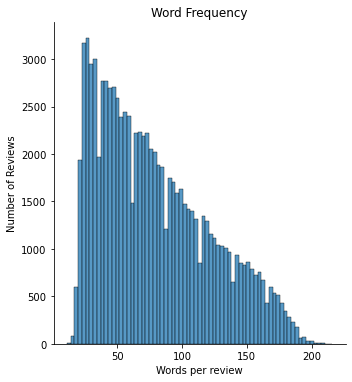

In [4]:
#Display #word per review distribution
words_per_review = list(map(lambda x: len(x.split()), train_sent))

sns.displot(words_per_review)
plt.xlabel('Words per review')
plt.ylabel('Number of Reviews')
plt.title('Word Frequency')
plt.show()

### Identify distribution of good vs bad reviews

mean: 78.68, median 70.0, max words: 216, min words: 11
0    45217
1    44783
Name: good_review, dtype: int64


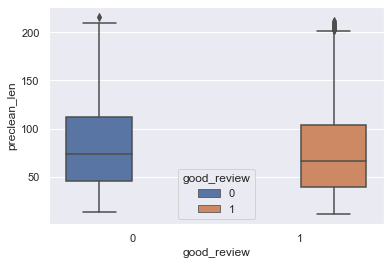

In [5]:
def list_stats(x):
    print('mean: {}, median {}, max words: {}, min words: {}'.
          format(round(np.mean(x),2),np.median(x),np.max(x), np.min(x)))


list_stats(words_per_review)
    # mean: 78.48, median 70.0, max words: 257, min words: 2

#Label each review
    #label_2 = good review, label 1 = bad
    #0 --> bad reviews
    #1 --> good reviews
    
# def review_type(x):
#     return 1 if re.match("__label__2", x) is not None else 0

train_label = [0 if x[:10] == '__label__1' else 1 for x in sample_train]
test_label = [0 if x[:10] == '__label__1' else 1 for x in sample_test]

#create data frame storing review updates
review_length_train = list(map(lambda x: len(x.split()), train_sent))
review_length_test = list(map(lambda x: len(x.split()), test_sent))

temp_train_data = list(zip(train_label, train_sent, review_length_train))
temp_test_data = list(zip(test_label, test_sent, review_length_test))

train_df = pd.DataFrame(temp_train_data, columns = ('good_review', 'review_raw','preclean_len'))
test_df = pd.DataFrame(temp_test_data, columns = ('good_review', 'review_raw','preclean_len'))

print(train_df.good_review.value_counts())
    # #number of good and bad reviews are basically uniform
    # 0    45217
    # 1    44783
    # Name: good_review, dtype: int64
    
#compare words count by review type
sns.set_theme(style="darkgrid")
ax = sns.boxplot(x = 'good_review', y = 'preclean_len',
            hue="good_review",data = train_df)

# Data Cleaning
***

In [6]:
#identify if this review has a UR: 1 for true and 0 for False
url_key_word = ['www.', '.gov', '.net', '.org', 'http','https']

def url_check(x):
    url_with_review = []
    
    for i in np.arange(len(x)):
        if any(key_word in x[i] for key_word in url_key_word):
            url_with_review.append(1)
        else:
            url_with_review.append(0)
            
    return url_with_review
        
#url instances
# np.sum(url_with_review)
#     #9422 instances

train_df['with_url'] = url_check(train_sent)
test_df['with_url'] = url_check(test_sent)

train_df.head(3)

,good_review,review_raw,preclean_len,with_url
0,1,a different view of blink 182: if you bought t...,44,0
1,1,a holiday classic: this was one of my favorite...,41,0
2,0,np-700 mistake: do not buy this product--this ...,80,0


In [7]:
url_key = "(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?"

def url_replace(x):
    output = []
    
    for i in np.arange(len(x)):
        if any(key_word in x[i] for key_word in url_key_word):
            x[i] = re.sub(url_key, 'url', x[i])
        output.append(x[i])
        
    return output


train_sent = url_replace(train_sent)
test_sent = url_replace(test_sent)

train_df['url_replace'] = train_sent
test_df['url_replace'] = test_sent

train_df.head(3)

,good_review,review_raw,preclean_len,with_url,url_replace
0,1,a different view of blink 182: if you bought t...,44,0,a different view of blink 182: if you bought t...
1,1,a holiday classic: this was one of my favorite...,41,0,a holiday classic: this was one of my favorite...
2,0,np-700 mistake: do not buy this product--this ...,80,0,np-700 mistake: do not buy this product--this ...


In [8]:
#replace contractions

def contrac_replace(x):
    output = []
    for i in np.arange(len(x)):
        x[i] = [contractions.fix(word) for word in x[i].split()]
        output.append(' '.join(x[i]))
    return output

train_sent = contrac_replace(train_sent)
test_sent = contrac_replace(test_sent)
    
train_df['not_contrac'] = train_sent
test_df['not_contrac'] = test_sent

#tokenize words

train_sent = [word_tokenize(doc) for doc in train_sent]
test_sent = [word_tokenize(doc) for doc in test_sent]

train_df['tokenized'] = train_sent
test_df['tokenized'] = test_sent

train_df.head(3)

,good_review,review_raw,preclean_len,with_url,url_replace,not_contrac,tokenized
0,1,a different view of blink 182: if you bought t...,44,0,a different view of blink 182: if you bought t...,a different view of blink 182: if you bought t...,"[a, different, view, of, blink, 182, :, if, yo..."
1,1,a holiday classic: this was one of my favorite...,41,0,a holiday classic: this was one of my favorite...,a holiday classic: this was one of my favorite...,"[a, holiday, classic, :, this, was, one, of, m..."
2,0,np-700 mistake: do not buy this product--this ...,80,0,np-700 mistake: do not buy this product--this ...,np-700 mistake: do not buy this product--this ...,"[np-700, mistake, :, do, not, buy, this, produ..."


In [9]:
#remove punctuations

punc = string.punctuation

def remove_punc(corpus):
    output = []
    
    for docs in corpus:       
        temp_list = [word for word in docs if word not in punc]
            
        output.append(temp_list)                   
    return output

train_sent = remove_punc(train_sent)
test_sent = remove_punc(test_sent)

train_df['no_punc'] = train_sent
test_df['no_punc'] = test_sent

train_df.head(3)

,good_review,review_raw,preclean_len,with_url,url_replace,not_contrac,tokenized,no_punc
0,1,a different view of blink 182: if you bought t...,44,0,a different view of blink 182: if you bought t...,a different view of blink 182: if you bought t...,"[a, different, view, of, blink, 182, :, if, yo...","[a, different, view, of, blink, 182, if, you, ..."
1,1,a holiday classic: this was one of my favorite...,41,0,a holiday classic: this was one of my favorite...,a holiday classic: this was one of my favorite...,"[a, holiday, classic, :, this, was, one, of, m...","[a, holiday, classic, this, was, one, of, my, ..."
2,0,np-700 mistake: do not buy this product--this ...,80,0,np-700 mistake: do not buy this product--this ...,np-700 mistake: do not buy this product--this ...,"[np-700, mistake, :, do, not, buy, this, produ...","[np-700, mistake, do, not, buy, this, product,..."


In [10]:
def digit_replace(corpus):
    
    output = []
    
    for docs in corpus:       
        
        temp_list = []
        for word in docs:
            temp_list.extend([word if word.isdigit() == False else '0'])
            
        output.append(' '.join(temp_list))                   
    return output

train_sent = digit_replace(train_sent)
test_sent = digit_replace(test_sent)

train_df['digit_replace'] = digit_replace(train_sent)
test_df['digit_replace'] = digit_replace(test_sent)

train_df.head(3)


,good_review,review_raw,preclean_len,with_url,url_replace,not_contrac,tokenized,no_punc,digit_replace
0,1,a different view of blink 182: if you bought t...,44,0,a different view of blink 182: if you bought t...,a different view of blink 182: if you bought t...,"[a, different, view, of, blink, 182, :, if, yo...","[a, different, view, of, blink, 182, if, you, ...",a d i f f e r e n t v i e w o f b l i ...
1,1,a holiday classic: this was one of my favorite...,41,0,a holiday classic: this was one of my favorite...,a holiday classic: this was one of my favorite...,"[a, holiday, classic, :, this, was, one, of, m...","[a, holiday, classic, this, was, one, of, my, ...",a h o l i d a y c l a s s i c t h i s ...
2,0,np-700 mistake: do not buy this product--this ...,80,0,np-700 mistake: do not buy this product--this ...,np-700 mistake: do not buy this product--this ...,"[np-700, mistake, :, do, not, buy, this, produ...","[np-700, mistake, do, not, buy, this, product,...",n p - 0 0 0 m i s t a k e d o n o t b ...


In [11]:
#identify and remove 'stopwords' (i.e. the, a)

stopwords = stopwords.words('english')

train_df['rmv_stopwords'] = train_df['no_punc'].apply(lambda x: [word for word in x if word not in stopwords])
test_df['rmv_stopwords'] = test_df['no_punc'].apply(lambda x: [word for word in x if word not in stopwords])

train_df.head(3)

,good_review,review_raw,preclean_len,with_url,url_replace,not_contrac,tokenized,no_punc,digit_replace,rmv_stopwords
0,1,a different view of blink 182: if you bought t...,44,0,a different view of blink 182: if you bought t...,a different view of blink 182: if you bought t...,"[a, different, view, of, blink, 182, :, if, yo...","[a, different, view, of, blink, 182, if, you, ...",a d i f f e r e n t v i e w o f b l i ...,"[different, view, blink, 182, bought, cd, buyi..."
1,1,a holiday classic: this was one of my favorite...,41,0,a holiday classic: this was one of my favorite...,a holiday classic: this was one of my favorite...,"[a, holiday, classic, :, this, was, one, of, m...","[a, holiday, classic, this, was, one, of, my, ...",a h o l i d a y c l a s s i c t h i s ...,"[holiday, classic, one, favorite, holiday, sto..."
2,0,np-700 mistake: do not buy this product--this ...,80,0,np-700 mistake: do not buy this product--this ...,np-700 mistake: do not buy this product--this ...,"[np-700, mistake, :, do, not, buy, this, produ...","[np-700, mistake, do, not, buy, this, product,...",n p - 0 0 0 m i s t a k e d o n o t b ...,"[np-700, mistake, buy, product, --, price, ene..."


In [12]:
#identify each token's part of speech

train_df['pos_tag'] = train_df['rmv_stopwords'].apply(nltk.pos_tag)
test_df['pos_tag'] = test_df['rmv_stopwords'].apply(nltk.pos_tag)

#wordnet pos tag
def pos_tagger(nltk_tag): 
    if nltk_tag.startswith('J'): 
        return wordnet.ADJ 
    elif nltk_tag.startswith('V'): 
        return wordnet.VERB 
    elif nltk_tag.startswith('N'): 
        return wordnet.NOUN 
    elif nltk_tag.startswith('R'): 
        return wordnet.ADV 
    else:           
        return None

train_df['wnl_pos'] = train_df['pos_tag'].apply(lambda x: [(word, pos_tagger(tag)) for (word, tag) in x])
test_df['wnl_pos'] = test_df['pos_tag'].apply(lambda x: [(word, pos_tagger(tag)) for (word, tag) in x])

train_df.head(3)

,good_review,review_raw,preclean_len,with_url,url_replace,not_contrac,tokenized,no_punc,digit_replace,rmv_stopwords,pos_tag,wnl_pos
0,1,a different view of blink 182: if you bought t...,44,0,a different view of blink 182: if you bought t...,a different view of blink 182: if you bought t...,"[a, different, view, of, blink, 182, :, if, yo...","[a, different, view, of, blink, 182, if, you, ...",a d i f f e r e n t v i e w o f b l i ...,"[different, view, blink, 182, bought, cd, buyi...","[(different, JJ), (view, NN), (blink, VBP), (1...","[(different, a), (view, n), (blink, v), (182, ..."
1,1,a holiday classic: this was one of my favorite...,41,0,a holiday classic: this was one of my favorite...,a holiday classic: this was one of my favorite...,"[a, holiday, classic, :, this, was, one, of, m...","[a, holiday, classic, this, was, one, of, my, ...",a h o l i d a y c l a s s i c t h i s ...,"[holiday, classic, one, favorite, holiday, sto...","[(holiday, NN), (classic, JJ), (one, CD), (fav...","[(holiday, n), (classic, a), (one, None), (fav..."
2,0,np-700 mistake: do not buy this product--this ...,80,0,np-700 mistake: do not buy this product--this ...,np-700 mistake: do not buy this product--this ...,"[np-700, mistake, :, do, not, buy, this, produ...","[np-700, mistake, do, not, buy, this, product,...",n p - 0 0 0 m i s t a k e d o n o t b ...,"[np-700, mistake, buy, product, --, price, ene...","[(np-700, JJ), (mistake, NN), (buy, NN), (prod...","[(np-700, a), (mistake, n), (buy, n), (product..."


In [13]:
#Lemmatize
wnl = WordNetLemmatizer()

def lemmatized(doc):
    
    lemmatized_sentence = [] 
    for word, tag in doc: 
        if tag is None: 
            # if there is no available tag, append the token as is 
            lemmatized_sentence.append(word) 
        else:         
            # else use the tag to lemmatize the token 
            lemmatized_sentence.append(wnl.lemmatize(word, tag)) 

    return lemmatized_sentence
train_df['lemmatized']= train_df['wnl_pos'].apply(lemmatized)
test_df['lemmatized']= test_df['wnl_pos'].apply(lemmatized)

train_df.head(3)

,good_review,review_raw,preclean_len,with_url,url_replace,not_contrac,tokenized,no_punc,digit_replace,rmv_stopwords,pos_tag,wnl_pos,lemmatized
0,1,a different view of blink 182: if you bought t...,44,0,a different view of blink 182: if you bought t...,a different view of blink 182: if you bought t...,"[a, different, view, of, blink, 182, :, if, yo...","[a, different, view, of, blink, 182, if, you, ...",a d i f f e r e n t v i e w o f b l i ...,"[different, view, blink, 182, bought, cd, buyi...","[(different, JJ), (view, NN), (blink, VBP), (1...","[(different, a), (view, n), (blink, v), (182, ...","[different, view, blink, 182, buy, cd, buy, en..."
1,1,a holiday classic: this was one of my favorite...,41,0,a holiday classic: this was one of my favorite...,a holiday classic: this was one of my favorite...,"[a, holiday, classic, :, this, was, one, of, m...","[a, holiday, classic, this, was, one, of, my, ...",a h o l i d a y c l a s s i c t h i s ...,"[holiday, classic, one, favorite, holiday, sto...","[(holiday, NN), (classic, JJ), (one, CD), (fav...","[(holiday, n), (classic, a), (one, None), (fav...","[holiday, classic, one, favorite, holiday, sto..."
2,0,np-700 mistake: do not buy this product--this ...,80,0,np-700 mistake: do not buy this product--this ...,np-700 mistake: do not buy this product--this ...,"[np-700, mistake, :, do, not, buy, this, produ...","[np-700, mistake, do, not, buy, this, product,...",n p - 0 0 0 m i s t a k e d o n o t b ...,"[np-700, mistake, buy, product, --, price, ene...","[(np-700, JJ), (mistake, NN), (buy, NN), (prod...","[(np-700, a), (mistake, n), (buy, n), (product...","[np-700, mistake, buy, product, --, price, ene..."


In [14]:
#post-cleaning, word count by doc

train_df['postclean_len'] = train_df['lemmatized'].apply(lambda x: len(x))
test_df['postclean_len'] = test_df['lemmatized'].apply(lambda x: len(x))
train_df.head(3)

,good_review,review_raw,preclean_len,with_url,url_replace,not_contrac,tokenized,no_punc,digit_replace,rmv_stopwords,pos_tag,wnl_pos,lemmatized,postclean_len
0,1,a different view of blink 182: if you bought t...,44,0,a different view of blink 182: if you bought t...,a different view of blink 182: if you bought t...,"[a, different, view, of, blink, 182, :, if, yo...","[a, different, view, of, blink, 182, if, you, ...",a d i f f e r e n t v i e w o f b l i ...,"[different, view, blink, 182, bought, cd, buyi...","[(different, JJ), (view, NN), (blink, VBP), (1...","[(different, a), (view, n), (blink, v), (182, ...","[different, view, blink, 182, buy, cd, buy, en...",21
1,1,a holiday classic: this was one of my favorite...,41,0,a holiday classic: this was one of my favorite...,a holiday classic: this was one of my favorite...,"[a, holiday, classic, :, this, was, one, of, m...","[a, holiday, classic, this, was, one, of, my, ...",a h o l i d a y c l a s s i c t h i s ...,"[holiday, classic, one, favorite, holiday, sto...","[(holiday, NN), (classic, JJ), (one, CD), (fav...","[(holiday, n), (classic, a), (one, None), (fav...","[holiday, classic, one, favorite, holiday, sto...",19
2,0,np-700 mistake: do not buy this product--this ...,80,0,np-700 mistake: do not buy this product--this ...,np-700 mistake: do not buy this product--this ...,"[np-700, mistake, :, do, not, buy, this, produ...","[np-700, mistake, do, not, buy, this, product,...",n p - 0 0 0 m i s t a k e d o n o t b ...,"[np-700, mistake, buy, product, --, price, ene...","[(np-700, JJ), (mistake, NN), (buy, NN), (prod...","[(np-700, a), (mistake, n), (buy, n), (product...","[np-700, mistake, buy, product, --, price, ene...",41


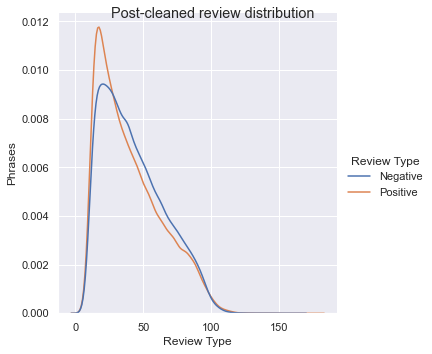

In [15]:
ax = sns.displot(data = train_df, x = 'postclean_len', hue = 'good_review', kind = 'kde')
ax.fig.suptitle("Post-cleaned review distribution", fontdict={"weight": "bold"})
ax.set(xlabel='Review Type', ylabel = 'Phrases')
ax.legend.set_title("Review Type")
new_labels = ['Negative', 'Positive']
for t, l in zip(ax._legend.texts, new_labels): t.set_text(l)

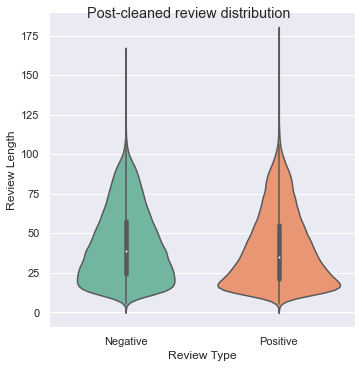

In [16]:
ax = sns.catplot(data = train_df, y = 'postclean_len', palette = "Set2",x = 'good_review', kind = 'violin')
ax.fig.suptitle("Post-cleaned review distribution", fontdict={"weight": "bold"})
ax.set_axis_labels(x_var="Review Type", y_var="Review Length")
ax.set(xticklabels=["Negative","Positive"])

In [17]:
#post-clean datat stats by review type
print('stats for positive reviews:')
print(list_stats(train_df.loc[train_df['good_review']==0]['postclean_len']))
print()
print('stats for positive reviews')
print(list_stats(train_df.loc[train_df['good_review']==1]['postclean_len']))

stats for positive reviews:
mean: 42.84, median 39.0, max words: 162, min words: 5
None

stats for positive reviews
mean: 40.32, median 35.0, max words: 175, min words: 5
None


In [18]:
#join tokenized words back into sentences
train_df['sentences'] = train_df['lemmatized'].apply(lambda x: ' '.join(x))
train_df['sentences'] = train_df['lemmatized'].apply(lambda x: ' '.join(x))

#new df with cleaned words and sentences
df_train = train_df.loc[:,['good_review', 'postclean_len','lemmatized']]
df_test = test_df.loc[:,['good_review', 'postclean_len','lemmatized']]

#lemmatized sentences
df_train['lemm_sent'] = df_train['lemmatized'].apply(lambda x: ' '.join(x))
df_test['lemm_sent'] = df_test['lemmatized'].apply(lambda x: ' '.join(x))

#identify in english review type
df_train['review_type'] = df_train.good_review.map({0:'bad', 1:'good'})
df_test['review_type'] = df_test.good_review.map({0:'bad', 1:'good'})

df_train.head(3)

,good_review,postclean_len,lemmatized,lemm_sent,review_type
0,1,21,"[different, view, blink, 182, buy, cd, buy, en...",different view blink 182 buy cd buy enema stat...,good
1,1,19,"[holiday, classic, one, favorite, holiday, sto...",holiday classic one favorite holiday story chi...,good
2,0,41,"[np-700, mistake, buy, product, --, price, ene...",np-700 mistake buy product -- price energizer ...,bad


In [19]:
#Check data distribution
df_train.review_type.value_counts()
#review's distribution appears equal / uniform

bad     45217
good    44783
Name: review_type, dtype: int64

In [20]:
#create a final dataframe of relevant relevant columns
final_train = df_train[:][['lemm_sent','good_review', 'review_type']]
final_test = df_test[:][['lemm_sent','good_review', 'review_type']]

final_train.columns = ['text', 'val', 'label']
final_test.columns = ['text', 'val', 'label']

final_train.head(3)

,text,val,label
0,different view blink 182 buy cd buy enema stat...,1,good
1,holiday classic one favorite holiday story chi...,1,good
2,np-700 mistake buy product -- price energizer ...,0,bad


# Hyper-Parameter Tuning

In [21]:
#test train split
X, y = final_train.text, final_train.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=rand_seed)


#pipeline setup
tfidf_bnb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('bnb', BernoulliNB())
    ])

tfidf_lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 20000, random_state=rand_seed))
    ])
#fit data into pipeline
tfidf_bnb_pipe.fit(X_train, y_train)
tfidf_lr_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('lr', LogisticRegression(max_iter=20000))])

In [22]:
#Parameters of each pipeline for gridsearch
bnb_tfidf_params= {
    'tfidf__ngram_range':((1,1), (1,2), (1,3)),
    "tfidf__max_features":(5000, 10000, 12000),
    'tfidf__use_idf': (True, False),
    "bnb__alpha" : (.2, .4, .8, .9, 1.0)
    }

lr_tfidf_params= {
    'tfidf__ngram_range':((1,1), (1,2)),
    "tfidf__max_features":(5000, 10000, 12000),
    'tfidf__use_idf': (True, False),
    'lr__C': (0.1,0.5, 1, 2),
    'lr__penalty': ['none','l2']
    }


In [23]:
#TFIDF Vectorizer Grid Search
gsearch_tfidf_bnb = GridSearchCV(tfidf_bnb_pipe, param_grid=bnb_tfidf_params,
                                 cv = 3, verbose = 1, n_jobs = -1)
gsearch_tfidf_lr = GridSearchCV(tfidf_lr_pipe, param_grid=lr_tfidf_params,
                                 cv = 3, verbose = 1, n_jobs = -1)

In [24]:
#fit training data into grid search for best params
#Best Param with Bernoulli Naive Bayes, TFIDF Vectorization

gsearch_tfidf_bnb.fit(X_train,y_train)

print("GridSearch Best Params: ")
print(gsearch_tfidf_bnb.best_params_)
print()
print('Overall Accuracy: '.format(gsearch_tfidf_bnb.best_score_))
print(gsearch_tfidf_bnb.best_score_)


Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 12.2min finished


GridSearch Best Params: 
{'bnb__alpha': 0.2, 'tfidf__max_features': 12000, 'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': True}

Overall Accuracy: 
0.8506944444444445


In [25]:
#Results Param with Logistic Regression, TFIDF Vectorization   

gsearch_tfidf_lr.fit(X_train,y_train)

print("GridSearch Best Params: ")
print(gsearch_tfidf_lr.best_params_)
print()
print('Overall Accuracy: ')
print(gsearch_tfidf_lr.best_score_)


Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 31.9min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 47.1min finished


GridSearch Best Params: 
{'lr__C': 2, 'lr__penalty': 'l2', 'tfidf__max_features': 12000, 'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': True}

Overall Accuracy: 
0.8816666666666667


# Model Training

### One Fold: Bernoulli Naive Bayes Model

In [38]:
#TFIDFVectorizer BNB Training
tfidf_bnb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=1.00, use_idf= True,
                              max_features=12000, ngram_range = (1,2))),
    ('bnb', BernoulliNB(alpha = 0.2))
    ])

%time tfidf_bnb_pipe.fit(X_train, y_train)
%time predict = tfidf_bnb_pipe.predict(X_test)

print('Overall Accuracy Score: ',metrics.accuracy_score(y_test, predict))
print()
print('Confusion Matrix: ')
print(confusion_matrix(y_test, predict))
print()
print('Classification Report: ')
print(classification_report(y_test, predict))        

Wall time: 7.97 s
Wall time: 577 ms
Overall Accuracy Score:  0.8518888888888889

Confusion Matrix: 
[[3731  768]
 [ 565 3936]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4499
           1       0.84      0.87      0.86      4501

    accuracy                           0.85      9000
   macro avg       0.85      0.85      0.85      9000
weighted avg       0.85      0.85      0.85      9000



### One- Fold: Linear Regression Model

In [39]:
tfidf_lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer( max_df=1.00, use_idf= True,
                              max_features=12000, ngram_range = (1,2))),
    ('lr', LogisticRegression(max_iter = 20000, random_state=rand_seed,
                              C = 2, penalty = 'l2'))
    ])

%time tfidf_lr_pipe.fit(X_train, y_train)
%time predict = tfidf_lr_pipe.predict(X_test)

print('Overall Accuracy Score: ',metrics.accuracy_score(y_test, predict))
print()
print('Confusion Matrix: ')
print(confusion_matrix(y_test, predict))
print()
print('Classification Report: ')
print(classification_report(y_test, predict))   

Wall time: 9.58 s
Wall time: 573 ms
Overall Accuracy Score:  0.8891111111111111

Confusion Matrix: 
[[3986  513]
 [ 485 4016]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4499
           1       0.89      0.89      0.89      4501

    accuracy                           0.89      9000
   macro avg       0.89      0.89      0.89      9000
weighted avg       0.89      0.89      0.89      9000



## Ten-Fold Cross Validation

In [29]:
#run 10 fold cross validation on training data
kf = KFold(n_splits=10, shuffle=True, random_state=rand_seed)

### Ten-Fold: Bernoulli Naive Bayes Model

In [40]:
#BernoulliNB 10 fold cross validation
scores = []
confusion = np.array([[0,0], [0,0]])

tfidf_bnb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 0.00, max_df=1.00, max_features=10000, ngram_range = (1,2))),
    ('bnb', BernoulliNB(alpha = 0.2))
    ])

for train_indices, test_indices in kf.split(final_train):
    X_train = final_train.iloc[train_indices]['text']
    y_train = final_train.iloc[train_indices]['val']
    
    X_test = final_train.iloc[test_indices]['text']
    y_test = final_train.iloc[test_indices]['val']
     
    tfidf_bnb_pipe.fit(X_train, y_train)    
    predict = tfidf_bnb_pipe.predict(X_test)    
    
    confusion += confusion_matrix(y_test, predict)
    # print(confusion)
    score = f1_score(y_test, predict)
    scores.append(score)
print()
print('Overall Score:',round(sum(scores)/len(scores),2))
print()
print('Confusion Matrix: ')
print()
print('Classification Report: ')
print(classification_report(y_test, predict))


Overall Score: 0.85

Confusion Matrix: 

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.82      0.84      4493
           1       0.83      0.87      0.85      4507

    accuracy                           0.85      9000
   macro avg       0.85      0.85      0.85      9000
weighted avg       0.85      0.85      0.85      9000



### Ten-Fold: Logistic Regression Model

In [31]:
scores = []
confusion = np.array([[0,0], [0,0]])

tfidf_lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(min_df = 0.00, max_df=1.00, use_idf= True,
                              max_features=12000, ngram_range = (1,2))),
    ('lr', LogisticRegression(max_iter = 20000, random_state=rand_seed,
                              C = 2, penalty = 'l2'))
    ])

for train_indices, test_indices in kf.split(final_train):
    X_train = final_train.iloc[train_indices]['text']
    y_train = final_train.iloc[train_indices]['val']
    
    X_test = final_train.iloc[test_indices]['text']
    y_test = final_train.iloc[test_indices]['val']
     
    tfidf_lr_pipe.fit(X_train, y_train)    
    predict = tfidf_lr_pipe.predict(X_test)    
    
    confusion += confusion_matrix(y_test, predict)
    # print(confusion)
    score = f1_score(y_test, predict)
    scores.append(score)
print()
print('Overall Score:',round(sum(scores)/len(scores),2))
print()
print('Confusion Matrix: ')
# print(confusion)
print()
print('Classification Report: ')
print(classification_report(y_test, predict))


Overall Score: 0.89

Confusion Matrix: 

Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4499
           1       0.89      0.89      0.89      4501

    accuracy                           0.89      9000
   macro avg       0.89      0.89      0.89      9000
weighted avg       0.89      0.89      0.89      9000



# Accuracy against testing dataset

In [32]:
#Separate training and testing data
final_X_train, final_y_train = final_train.text, final_train.label
final_X_test, final_y_test = final_test.text, final_test.label

### BernoulliNB TFIDF Vectorization

In [33]:
%time tfidf_bnb_pipe.fit(final_X_train, final_y_train)
%time predict = tfidf_bnb_pipe.predict(final_X_test)
print()
print('Test Set Accuracy Score: ',metrics.accuracy_score(final_y_test, predict))
print()
print('Confusion Matrix: ')
print(confusion_matrix(final_y_test, predict))
print()
print('Classification Report: ')
print(classification_report(final_y_test, predict))  

Wall time: 10.2 s
Wall time: 724 ms

Test Set Accuracy Score:  0.8511

Confusion Matrix: 
[[4149  850]
 [ 639 4362]]

Classification Report: 
              precision    recall  f1-score   support

         bad       0.87      0.83      0.85      4999
        good       0.84      0.87      0.85      5001

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



### Logistic Regression TFIDF Vectorizations

In [34]:
%time tfidf_lr_pipe.fit(final_X_train, final_y_train)
%time predict = tfidf_lr_pipe.predict(final_X_test)
print()
print('Test Set Accuracy Score: ',metrics.accuracy_score(final_y_test, predict))
print()
print('Confusion Matrix: ')
print(confusion_matrix(final_y_test, predict))
print()
print('Classification Report: ')
print(classification_report(final_y_test, predict))  

Wall time: 12.4 s
Wall time: 761 ms

Test Set Accuracy Score:  0.8879

Confusion Matrix: 
[[4417  582]
 [ 539 4462]]

Classification Report: 
              precision    recall  f1-score   support

         bad       0.89      0.88      0.89      4999
        good       0.88      0.89      0.89      5001

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## Display top phrases by review type

In [35]:
# grouped_reviews(final_train)
good_train_rev, good_train_label = final_train.loc[final_train.val == 1].text, final_train.loc[final_train.val == 1].label
bad_train_rev, bad_train_label = final_train.loc[final_train.val == 0].text, final_train.loc[final_train.val == 0].label

# Identify most important phrases
def word_importance(vectorizer,classifier,n=20):
    # self._vectorizer = vectorizer
    #class_labels = classifier.coef_
    feature_names = vectorizer.get_feature_names()

    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]

    class1_frequency_dict = {}
    class2_frequency_dict = {}
    
    for coef, feat in topn_class1:
        class1_frequency_dict.update( {feat : coef} )

    for coef, feat in topn_class2:
        class2_frequency_dict.update( {feat : coef} )

    return (class1_frequency_dict, class2_frequency_dict)

In [50]:
#models with optimal parameters
tfidf = TfidfVectorizer(min_df = 0.00, max_df=1.00, max_features=10000, ngram_range = (2,3))
bnb = BernoulliNB(alpha = 0.4)

### Top N most frequent Terms

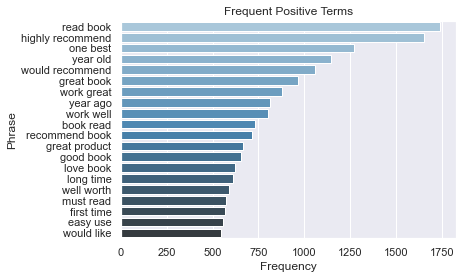

In [51]:
#display most frequent terms by review
doc = tfidf.fit_transform(good_train_rev)

bnb.fit(doc, good_train_label)

positive_frequency_dict, pos_frequency_dict = word_importance(tfidf, bnb)
positive_feature_freq = pd.DataFrame(positive_frequency_dict.items(), columns = ["feature_word", "frequency"])  
pos_feature_freq = pd.DataFrame(pos_frequency_dict.items(), columns = ["feature_word", "frequency"])  

ax = sns.barplot(x = 'frequency', y = 'feature_word',palette="Blues_d", data = positive_feature_freq)
ax.set_title('Frequent Positive Terms')
ax.set(xlabel='Frequency', ylabel = 'Phrase')
plt.show()
ax.clear() 


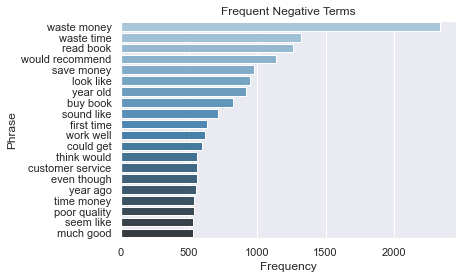

In [52]:
negative_train_rev, negative_train_val = final_train.loc[final_train.val == 0].text, final_train.loc[final_train.val == 0].val
docs = tfidf.fit_transform(negative_train_rev)
bnb.fit(docs, negative_train_val)

negative_frequency_dict, pos_frequency_dict = word_importance(tfidf, bnb)
negative_feature_freq = pd.DataFrame(negative_frequency_dict.items(), columns = ["feature_word", "frequency"])  
pos_feature_freq = pd.DataFrame(pos_frequency_dict.items(), columns = ["feature_word", "frequency"])  

ax = sns.barplot(x = 'frequency', y = 'feature_word', palette="Blues_d",data = negative_feature_freq)
ax.set_title('Frequent Negative Terms')
ax.set(xlabel='Frequency', ylabel = 'Phrase')
plt.show()
ax.clear() 

### TFIDF Top N Terms

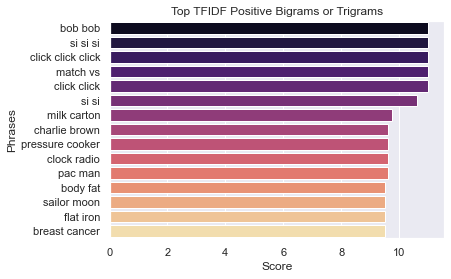

In [53]:
tfidf.fit(good_train_rev)
list_good = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
list_good = pd.DataFrame.from_dict(list_good, orient='index')
list_good.reset_index(inplace = True)
list_good = list_good.rename(columns = {'index': 'phrases', 0:'tfidf_score'})
list_good = list_good.sort_values(by = ['tfidf_score'], ascending = False)

ax = sns.barplot(x = 'tfidf_score', y = 'phrases', palette="magma",data = list_good.head(15))
ax.set_title('Top TFIDF Positive Bigrams or Trigrams')
ax.set(xlabel='Score', ylabel = 'Phrases')
plt.show()
ax.clear() 

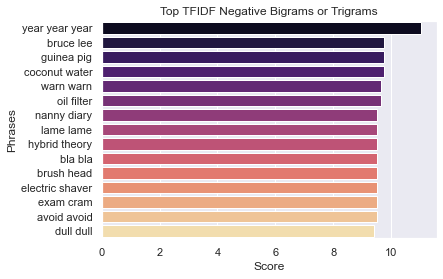

In [54]:
tfidf.fit(bad_train_rev)
list_bad = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
list_bad = pd.DataFrame.from_dict(list_bad, orient='index')
list_bad.reset_index(inplace = True)
list_bad = list_bad.rename(columns = {'index': 'phrases', 0:'tfidf_score'})
list_bad = list_bad.sort_values(by = ['tfidf_score'], ascending = False)

ax = sns.barplot(x = 'tfidf_score', y = 'phrases',palette="magma", data = list_bad.head(15))
ax.set_title('Top TFIDF Negative Bigrams or Trigrams')
ax.set(xlabel='Score', ylabel = 'Phrases')
plt.show()
ax.clear()